# Porce model 

Pools:

$x_1$: folige

$x_2$: wood

$x_3$: fine roots

$x_4$: coarse roots

$x_5$: fine litter
 
$x_6$: coarse woody debris

$x_7$: soil carbon


## Libraries

In [2]:
import numpy as np
import pandas as pd 
from sympy import *
from LAPM import *
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel
from LAPM import phase_type
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
from sympy.abc import y

## Parameter values

In [3]:
psname=['Foliage','Wood','Fine roots','Coarse roots','Fine litter','Coarse woody debris','Soil carbon','Ecosystem']
psname=['Foliage','Wood','Fine roots','Coarse roots','Fine litter','Coarse woody','Soil carbon','Ecosystem']

f_fol=0.08 # Proportion of foliage. **
f_wood=0.92 # Proportion of wood. **
nps=7 # number of pools.
GPP=23.98 # Gross primary production [MgC ha-1 yr-1].

### Cycling rate
k1=2.978 # in foliage.
k2=0.035 # in wood.
k3=0.027 # in fine roots.
k4=0.022 # in coarse roots.
k5=2.594 # in fine litter.
k6=0.519 # in coarse woody debris.
k7=0.024 # in soil carbon.

### Inputs from the atmosphere.
u1=GPP; u2=0; u3=0; u4=0; u5=0; u6=0; u7=0

### Proportion transferred from x_i to x_j (a_{ji}).
a21=0.158; a31=0.009; a41=0.031; a51=0.251; a61=0.; a71=0.
a32=0.   ; a42=0.   ; a52=0.   ; a62=0.249; a72=0.
a43=0    ; a53=0.997; a63=0.   ; a73=0.
a54=0.   ; a64=0.001; a74=0.
a65=0.   ; a75=0.256
a76=0.988

## Equations system

In [4]:
B=eye(nps)*-1 # matrix representing all cycling and transfer rates of carbon within the ecosystem.

B[0,0]=-k1; B[1,0]=a21*k1; B[2,0]=a31*k1; B[3,0]=a41*k1; B[4,0]=a51*k1; B[5,0]=a61*k1; B[6,0]=a71*k1
B[1,1]=-k2; B[2,1]=a32*k2; B[3,1]=a42*k2; B[4,1]=a52*k2; B[5,1]=a62*k2; B[6,1]=a72*k2
B[2,2]=-k3; B[3,2]=a43*k3; B[4,2]=a53*k3; B[5,2]=a63*k3; B[6,2]=a73*k3
B[3,3]=-k4; B[4,3]=a54*k4; B[5,3]=a64*k4; B[6,3]=a74*k4
B[4,4]=-k5; B[5,4]=a65*k5; B[6,4]=a75*k5
B[5,5]=-k6; B[6,5]=a76*k6
B[6,6]=-k7
B=Matrix(nps,nps,B)
B

Matrix([
[  -2.978,        0,        0,      0,        0,        0,      0],
[0.470524,   -0.035,        0,      0,        0,        0,      0],
[0.026802,        0,   -0.027,      0,        0,        0,      0],
[0.092318,        0,        0, -0.022,        0,        0,      0],
[0.747478,        0, 0.026919,      0,   -2.594,        0,      0],
[       0, 0.008715,        0, 2.2e-5,        0,   -0.519,      0],
[       0,        0,        0,      0, 0.664064, 0.512772, -0.024]])

In [5]:
u=Matrix(nps, 1, [u1,u2,u3,u4,u5,u6,u7]) # vector of C inputs from atmosphere.
u

Matrix([
[23.98],
[    0],
[    0],
[    0],
[    0],
[    0],
[    0]])

In [7]:
t=Symbol("t")
t0=Symbol("t0")
M=LinearAutonomousPoolModel(u,B)

## Ages

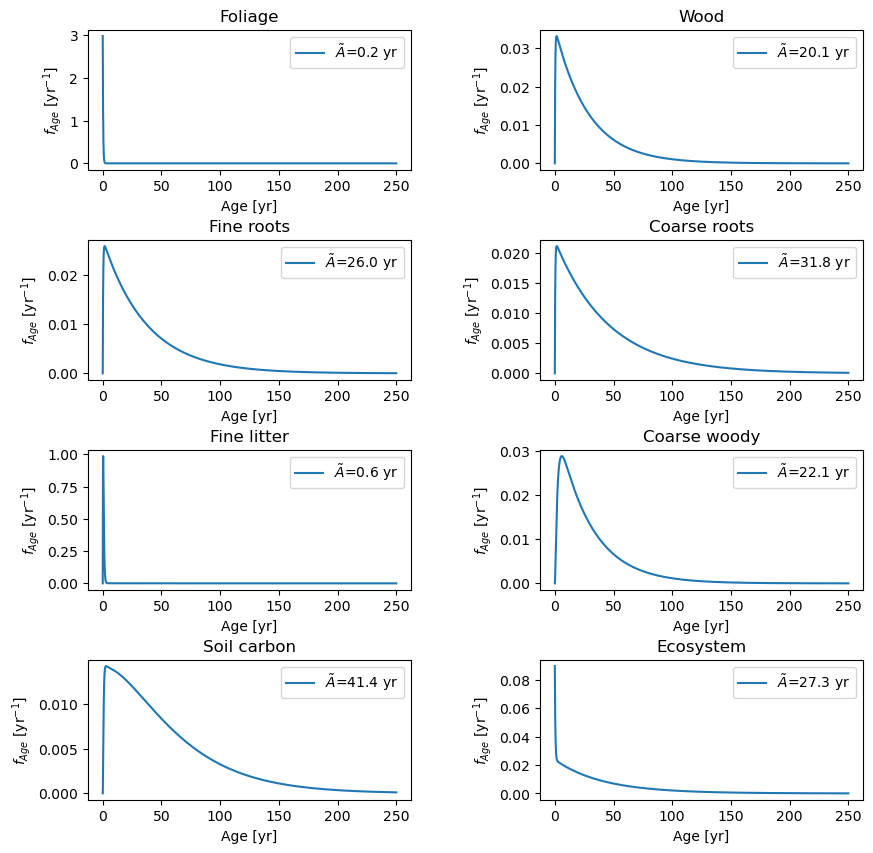

In [9]:
ny=250; nd=0.01; nt=int(ny/nd)
ages=np.arange(0,ny,nd)
pdfs_ages=np.zeros([ages.size,nps+1]) # ages of carbon in each pool and at the last position, the ecosystem.
median_age=np.zeros(nps+1) # median of carbon age.

f_age_pools=lambdify(y,M.a_density(y),'numpy') # function to evaluate the age of C of each pool. 
f_age_ecos=lambdify(y,M.A_density(y),'numpy') # function to evaluate the age of C of the ecosystem. 

pdfs_ages[:,nps]=f_age_ecos(ages) # density values.
pdfs_ages[:,0:nps]=f_age_pools(ages).reshape(nps,nt).T

median_age[nps]=M.A_quantile(0.5) 
median_age[0:nps]=M.a_quantile(0.5) 

rows,cols=int(np.ceil((nps+1)/2)),2
fig,axs=plt.subplots(rows,cols,figsize=(10,10))
#for i in range(nps+1):
w=0
for row in range(rows):
    for col in range(cols):
        axs[row,col].plot(ages,pdfs_ages[:,w],label=r'$\tilde{A}$='+str(round(median_age[w],1))+' yr')
        axs[row,col].set_title(psname[w])
        axs[row,col].set_xlabel('Age [yr]')
        axs[row,col].set_ylabel(r'$f_{Age}$ [yr$^{-1}$]')
        axs[row,col].legend()
        w=w+1

plt.subplots_adjust(wspace=0.4,hspace=0.5)


## Transit time

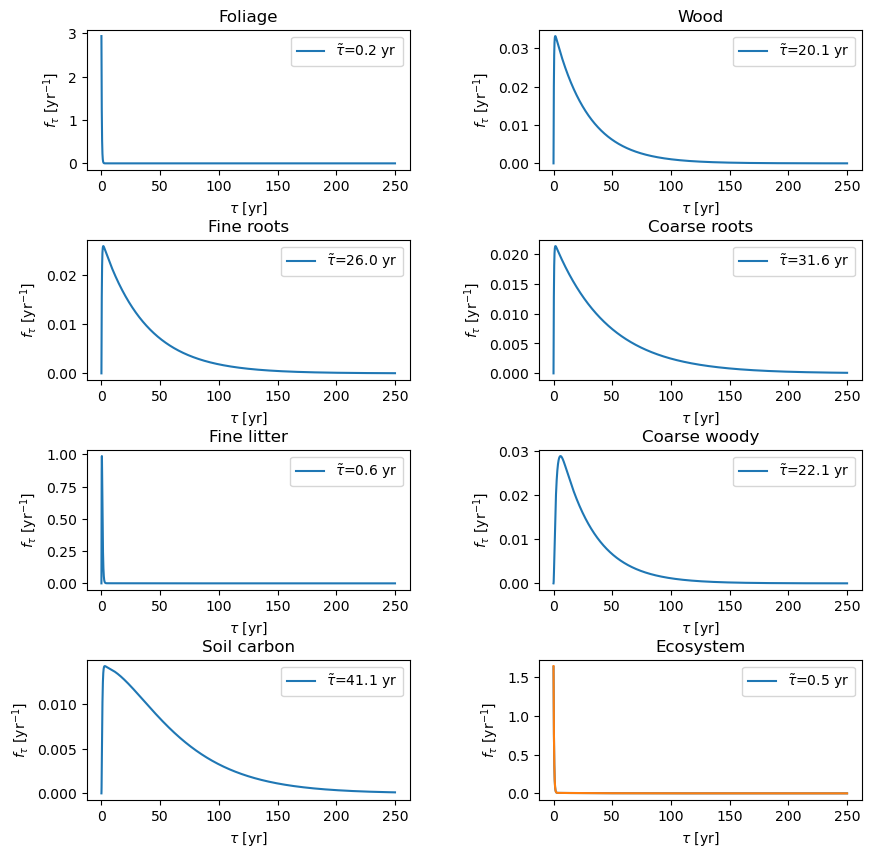

In [10]:
pdfs_tt=np.zeros([ages.size,nps+1]) # transit time of carbon in each pool and at the last position, the ecosystem.
pdfs_tt_nn=np.zeros([ages.size,nps+1]) # non-normalized pdfs.
median_tt=np.zeros(nps+1) # median of carbon age.

f_tt_ecos=lambdify(y,M.T_density(y),'numpy') # function to evaluate the transit time of C of each pool. 
pdfs_test=f_tt_ecos(ages) # density values of transit time to test the tt at each pool.

# Calculate transit time distribution at each pool from the age distributions.
z=phase_type.z(B)
X=M.xss
z2=np.reshape(np.array(z),-1); x2=np.reshape(np.array(X),-1)
for i in range(nt):
    pdfs_tt[i,0:nps]=pdfs_ages[i,0:nps]*np.multiply(z2,x2)

pdfs_tt[:,nps]=np.sum(pdfs_tt[:,0:nps],axis=1)
pdf_tt_nn=np.copy(pdfs_tt)
pdf_tt_nn[:]=pdfs_tt[:]

for i in range(nps+1): # normalizes the pdfs and calculates the median.
    pdfs_tt[:,i]=pdfs_tt[:,i]/np.sum(pdfs_tt[:,i]*nd)
    cdf=np.cumsum(pdfs_tt[:,i]*nd)
    median_tt[i]=ages[np.argmin(np.abs(cdf-0.5))]
    
rows,cols=int(np.ceil((nps+1)/2)),2
fig,axs=plt.subplots(rows,cols,figsize=(10,10))
w=0
for row in range(rows):
    for col in range(cols):
        axs[row,col].plot(ages,pdfs_tt[:,w],label=r'$\tilde{\tau}$='+str(round(median_tt[w],1))+' yr')
        axs[row,col].set_title(psname[w])
        axs[row,col].set_xlabel(r'$\tau$ [yr]')
        axs[row,col].set_ylabel(r'$f_{\tau}$ [yr$^{-1}$]')
        axs[row,col].legend()
        w=w+1
axs[row,col].plot(ages,pdfs_test)
plt.subplots_adjust(wspace=0.4,hspace=0.5)

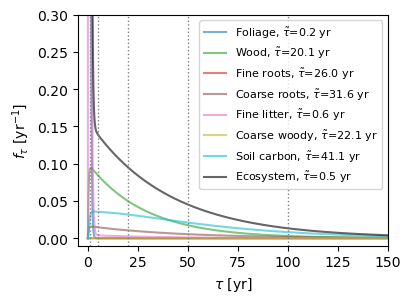

In [17]:
fig,ax=plt.subplots(figsize=(4,3))
colors[7,:]=0
for i in range(nps+1):
    if i<=nps-1:col=colors[i]
    else:col='black'
    ax.plot(ages,pdf_tt_nn[:,i],alpha=transp,label=psname[i]+r', $\tilde{\tau}$='+str(round(median_tt[i],1))+' yr',color=col)
ax.set_xlabel(r'$\tau$ [yr]')
ax.set_ylabel(r'$f_{\tau}$ [yr$^{-1}$]')
ax.set_xlim(-5,150)
ax.set_ylim(-0.01,0.3)
for i in range(t_per.size):ax.axvline(x=t_per[i],color='gray',linestyle='dotted',linewidth=1)
ax.legend(prop={'size':8})

plt.savefig('figure2a.pdf') 

### Percentage of carbon with a transit time x

In [11]:
t_per=np.array([1,5,20,50,100])
perc=np.zeros([t_per.size,nps+1]); perc2=np.zeros([t_per.size,nps+1])
da=ages[1]-ages[0]
for j in range(nps+1):
    for i in range(t_per.size):
        w=np.argmin(np.abs(ages-t_per[i]))
        perc[i,j]=np.sum(pdfs_tt[0:w,j]*da) # P[tau<=taux]
        perc2[i,j]=np.sum(pdfs_tt[w:-1,j]*da) # P[tau>=taux]
    

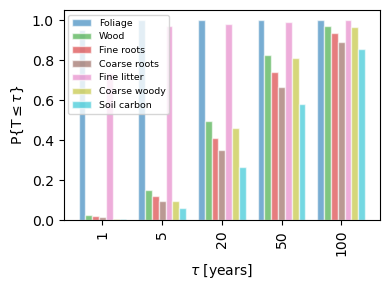

In [15]:
colors=plt.cm.tab10(np.linspace(0.05,1,nps))
z=np.array([0,0,0,0]) # color ecosystem
colors=np.vstack([colors,z])
transp=0.6 # transparency
a=np.vstack([colors,z])

# Make a data definition
data={psname[0]: perc[:,0]}
for i in range(1,nps):
    data[psname[i]]=perc[:,i]
df=pd.DataFrame(data,index=t_per)

# Multiple bar chart
df.plot.bar(color=colors,width=0.8,alpha=transp,edgecolor='white',figsize=(4,3)).legend(prop={'size':6.8})
plt.xlabel(r'$\tau$ [years]')
plt.ylabel(r'P{T$\leq\tau$}')

plt.tight_layout()
plt.savefig('Pleq.pdf') 

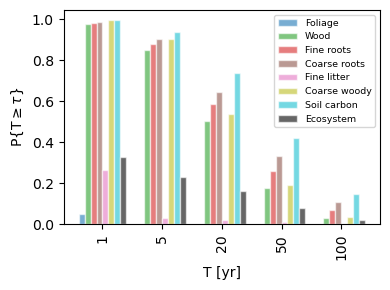

In [16]:
data={psname[0]: perc2[:,0]}
for i in range(1,nps+1):
    data[psname[i]]=perc2[:,i]
df=pd.DataFrame(data,index=t_per)

# Multiple bar chart
df.plot.bar(color=colors,width=0.8,alpha=transp,edgecolor='white',figsize=(4,3)).legend(prop={'size':6.8})
plt.xlabel(r'T [yr]')
plt.ylabel(r'P{T$\geq\tau$}')

plt.tight_layout()
plt.savefig('Pgeq.pdf') 

## Variations in $\textbf{u}$ and $\textbf{B}$

In [18]:
per=np.arange(0.5,1.75,0.25)
pdfsu=np.zeros([ages.size,len(per)]) # pdf for each value of u.
pdfsb=np.zeros([ages.size,len(per)]) # pdf for each value of B.
cdfsu=np.zeros([ages.size,len(per)]) # cdf for each value of u.
cdfsb=np.zeros([ages.size,len(per)]) # cdf for each value of B.
pdfsub=np.zeros([ages.size,len(per)]) # pdf varying both u and B.
medianu=np.zeros(len(per))
medianb=np.zeros(len(per))
for i in range(len(per)):
    u_v=u*per[i]; B_v=B*per[i]
    M1=LinearAutonomousPoolModel(u_v,B)
    M2=LinearAutonomousPoolModel(u_v,B_v)
    func_ecos1=lambdify(y,M1.T_density(y),'numpy') # function to evaluate the density function of the transit time ecosystem age. 
    func_ecos2=lambdify(y,M2.T_density(y),'numpy') # function to evaluate the density function of the C ecosystem transit time.  
    cum_ecos1=lambdify(y,M1.T_cum_dist_func(y),'numpy') # function to evaluate the cumulative distribution of the C ecosystem transit time. 
    cum_ecos2=lambdify(y,M2.T_cum_dist_func(y),'numpy') # function to evaluate the cumulative distribution of the C ecosystem transit time. 
    medianu[i]=M1.T_quantile(0.5) ; medianb[i]=M2.T_quantile(0.5)  

    pdfsu[:,i]=func_ecos1(ages)
    pdfsb[:,i]=func_ecos2(ages)

    cdfsu[:,i]=pdfsu[:,i]*u[0]*per[i]
    cdfsb[:,i]=pdfsb[:,i]*u[0]*per[i]

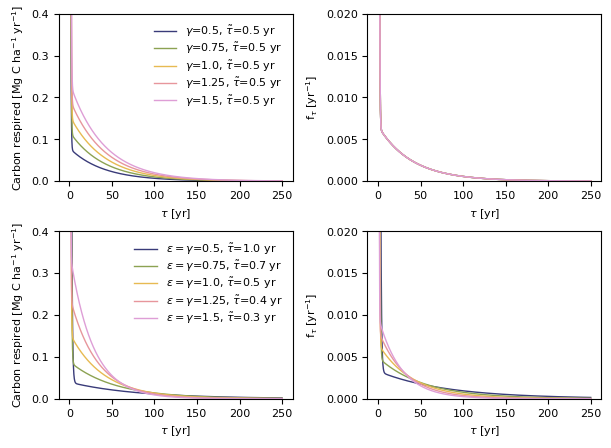

In [19]:
plt.rcParams.update({'font.size':8})
cmap=plt.cm.get_cmap('tab20b',len(per))
pdfs=np.zeros([ages.size,nps+1]) # each pool and at the last position, the ecosystem.

fig,axs=plt.subplots(2,2,figsize=(7,5))

for i in range(len(per)):
# Variation of u.   
    axs[0,0].plot(ages,cdfsu[:,i],color=cmap(i),linewidth=1,
                  label=r'$\gamma$='+str(per[i])+r', $\tilde{\tau}$='+str(round(medianu[i],1))+' yr')
    axs[0,0].set_xlabel(r'$\tau$ [yr]')
    axs[0,0].set_ylabel('Carbon respired [Mg C ha$^{-1}$ yr$^{-1}$]')
    axs[0,0].set_ylim(0,0.4)
    
    axs[0,1].plot(ages,pdfsu[:,i],color=cmap(i),linewidth=1,
                  label=str(per[i])+'u, median='+str(round(medianu[i],2))+' yr')
    axs[0,1].set_xlabel(r'$\tau$ [yr]')
    axs[0,1].set_ylabel(r'f$_{\tau}$ [yr$^{-1}$]')
    axs[0,1].set_ylim(0,0.02)
    
# Variation of B.    
    axs[1,0].plot(ages,cdfsb[:,i],color=cmap(i),linewidth=1,
                  label=r'$\varepsilon=\gamma$='+str(per[i])+r', $\tilde{\tau}$='+str(round(medianb[i],1))+' yr')
    axs[1,0].set_xlabel(r'$\tau$ [yr]')
    axs[1,0].set_ylabel('Carbon respired [Mg C ha$^{-1}$ yr$^{-1}$]')
    axs[1,0].set_ylim(0,0.4)
    
    axs[1,1].plot(ages,pdfsb[:,i],color=cmap(i),linewidth=1,
                  label=str(per[i])+'B, median='+str(round(medianb[i],1))+' yr')
    axs[1,1].set_xlabel(r'$\tau$ [yr]')
    axs[1,1].set_ylabel(r'f$_{\tau}$ [yr$^{-1}$]')
    axs[1,1].set_ylim(0,0.02)
axs[0,0].legend(frameon=False,labelspacing=0.2)
axs[1,0].legend(frameon=False,labelspacing=0.2)

plt.subplots_adjust(wspace=0.32,hspace=0.3)
plt.savefig('Sensitivity_tau.pdf',bbox_inches='tight')